Задание: 
Для сокращенных данных (train_cut_X и test_cut_X) реализовать метод отбора важности признаков по Шепли.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import math
from sklearn.metrics import r2_score
from itertools import chain, combinations


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [13]:
sns.set()

In [14]:
 df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")

In [15]:
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [16]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
train_X.columns

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'engine-type',
       'gear-type', 'luxury', 'max-speed', 'power-electro-kw', 'supply-system',
       'valves', 'valvetrain', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_front-brake',
       'configurations_safety-rating', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_group', 'models_light-and-commercial',
       'models_male'],
      dtype='object')

In [18]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

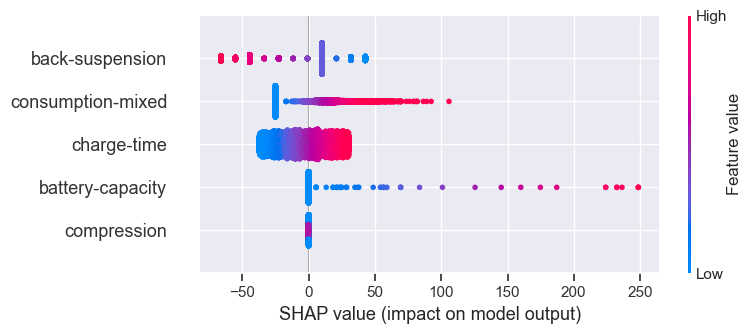

In [19]:
reg = LinearRegression().fit(train_cut_X, train_y)

explainer = shap.Explainer(reg, train_cut_X)
shap_values = explainer(test_cut_X)

shap.summary_plot(shap_values, test_cut_X)

In [20]:
all_features = train_cut_X.columns

In [21]:
i = all_features[0]
N = all_features[1:]

In [22]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

powerset_N = list(powerset(N))
powerset_N

[(),
 ('battery-capacity',),
 ('charge-time',),
 ('compression',),
 ('consumption-mixed',),
 ('battery-capacity', 'charge-time'),
 ('battery-capacity', 'compression'),
 ('battery-capacity', 'consumption-mixed'),
 ('charge-time', 'compression'),
 ('charge-time', 'consumption-mixed'),
 ('compression', 'consumption-mixed'),
 ('battery-capacity', 'charge-time', 'compression'),
 ('battery-capacity', 'charge-time', 'consumption-mixed'),
 ('battery-capacity', 'compression', 'consumption-mixed'),
 ('charge-time', 'compression', 'consumption-mixed'),
 ('battery-capacity', 'charge-time', 'compression', 'consumption-mixed')]

In [23]:
selected = []
for col in train_cut_X.columns: # цикл по столбцам (важность каждого)
    s = list(powerset(train_cut_X.columns)) # все возможные подмножества
    k = 0
    for _ in s:
        n = (math.factorial(len(s))*math.factorial((len(train_cut_X.columns)+len(s))))/math.factorial(len(train_cut_X.columns))
        model = LinearRegression().fit(train_cut_X, train_y)
        predictions = model.predict(test_cut_X)
        R2 = r2_score(test_y, predictions)

        train_cut_X_drop = train_cut_X.drop(col, axis=1)
        test_cut_X_drop = test_cut_X.drop(col, axis=1)
        reg1 = LinearRegression().fit(train_cut_X_drop, train_y)
        predictions1 = reg1.predict(test_cut_X_drop)

        R_2 = r2_score(test_y, predictions1)
        k += n*(R2**2-R_2**2)
    selected.append(k)
selected

[7.844275671030981e+74,
 9.284687109636915e+73,
 3.6868035391765185e+74,
 3.377456271263135e+71,
 5.216844990633313e+74]

In [24]:
# пары "признак - важность" в таблице
importance_dict = dict(zip(train_cut_X.columns, selected))
for feature, importance in importance_dict.items():
    print(f"признак: {feature}, важность: {importance}")

признак: back-suspension, важность: 7.844275671030981e+74
признак: battery-capacity, важность: 9.284687109636915e+73
признак: charge-time, важность: 3.6868035391765185e+74
признак: compression, важность: 3.377456271263135e+71
признак: consumption-mixed, важность: 5.216844990633313e+74


In [25]:
# MSE для всех признаков
MSE = mean_squared_error(test_y, predictions)
print('MSE:', MSE)

# MSE для всех признаков кроме одного
MSE1 = mean_squared_error(test_y, predictions1)
print('MSE1:', MSE1)

MSE: 55826.51541374291
MSE1: 56310.35433258204


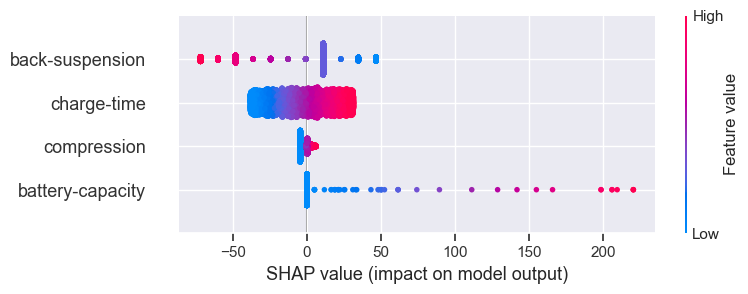

In [26]:
reg1 = LinearRegression().fit(train_cut_X_drop, train_y)
explainer = shap.Explainer(reg1, train_cut_X_drop)
shap_values = explainer(test_cut_X_drop)

shap.summary_plot(shap_values, test_cut_X_drop)

# Вывод:

Результаты реализованного нами совпадают с результатами встроенного метода шепли